In [555]:
import os 
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import time
import random
from pprint import pprint
from glob import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import FancyArrowPatch

import pyrender

import pygarment as pyg
import trimesh
import PIL
from PIL import Image

from analysis_utils import visualize_meshes_plotly, v_id_map, plot_panel_info

DATASET_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(DATASET_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(DATASET_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(DATASET_ROOT_PATH, "neutral_body/mean_all.obj")

default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)

print("body vertices", default_body_mesh.vertices.shape)
print("body faces", default_body_mesh.faces.shape)


# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))

body vertices (23751, 3)
body faces (47500, 3)


### Rendering Functions and Settings

In [550]:
# basic render utility functions

import os
import platform
if platform.system() == 'Linux':
    os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ['MESA_GL_VERSION_OVERRIDE'] = '4.1' 
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '410'

def rotate_matrix_y(matrix, angle_deg):
    rotation_angle = angle_deg * (np.pi / 180)

    # Define the rotation matrix for 180-degree rotation around the y-axis
    rotation_matrix = np.array([
        [np.cos(rotation_angle), 0, np.sin(rotation_angle), 0],
        [0, 1, 0, 0],
        [-np.sin(rotation_angle), 0, np.cos(rotation_angle), 0],
        [0, 0, 0, 1]
    ])

    # Apply the rotation to the mesh vertices
    rot_matrix = np.dot(rotation_matrix, matrix)
    return rot_matrix

def rotate_matrix_x(matrix, angle_deg):
    rotation_angle = angle_deg * (np.pi / 180)

    # Define the rotation matrix for 180-degree rotation around the y-axis
    rotation_matrix = np.array([
        [1, 0, 0, 0],
        [0, np.cos(rotation_angle), -np.sin(rotation_angle), 0],
        [0, np.sin(rotation_angle), np.cos(rotation_angle), 0],
        [0, 0, 0, 1]
    ])

    # Apply the rotation to the mesh vertices
    rot_matrix = np.dot(rotation_matrix, matrix)
    return rot_matrix

def create_lights(scene, intensity=30.0):
    light_positions = [
        np.array([1.60614, 1.5341, 1.23701]),
        np.array([1.31844, 1.92831, -2.52238]),
        np.array([-2.80522, 1.2594, 2.34624]),
        np.array([0.160261, 1.81789, 3.52215]),
        np.array([-2.65752, 1.41194, -1.26328])
    ]
    light_colors = [
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0]
    ]

    # Add lights to the scene
    for i in range(5):
        light = pyrender.PointLight(color=light_colors[i], intensity=intensity)
        light_pose = np.eye(4)
        light_pose[:3, 3] = light_positions[i]
        scene.add(light, pose=light_pose)



def create_camera(pyrender, pyrender_body_mesh, scene, side, camera_location=None):

    # Create a camera
    y_fov = np.pi / 6. 
    camera = pyrender.PerspectiveCamera(yfov=y_fov)
    

    if camera_location is None:
        # Evaluate w.r.t. body

        fov = 50  # Set your desired field of view in degrees 

        # # Calculate the bounding box center of the mesh
        bounding_box_center = pyrender_body_mesh.bounds.mean(axis=0)

        # Calculate the diagonal length of the bounding box
        diagonal_length = np.linalg.norm(pyrender_body_mesh.bounds[1] - pyrender_body_mesh.bounds[0])

        # Calculate the distance of the camera from the object based on the diagonal length
        distance = 1.5 * diagonal_length / (2 * np.tan(np.radians(fov / 2)))

        camera_location = bounding_box_center
        camera_location[-1] += distance

    # Calculate the camera pose
    camera_pose = np.array([
        [1.0, 0.0, 0.0, camera_location[0]],
        [0.0, 1.0, 0.0, camera_location[1]],
        [0.0, 0.0, 1.0, camera_location[2]],
        [0.0, 0.0, 0.0, 1.0]
    ])

    camera_pose = rotate_matrix_x(camera_pose, -15)
    camera_pose = rotate_matrix_y(camera_pose, 20)
    if side == 'back':
        camera_pose = rotate_matrix_y(camera_pose, 180)
    elif side == 'right':
        camera_pose = rotate_matrix_y(camera_pose, -90)
    elif side == 'left':
        camera_pose = rotate_matrix_y(camera_pose, 90)

    # Set camera's pose in the scene
    scene.add(camera, pose=camera_pose)
    
render_props = {
    "resolution": [800, 800],
    "sides": ["front", "back", "right", "left"],
    "front_camera_location": [0, 0.97, 4.15],
    "uv_texture": {
        "seam_width": 0.5,
        "dpi": 1500,
        "fabric_grain_texture_path": "./assets/img/fabric_texture.png",
        "fabric_grain_resolution": 5
    }
}


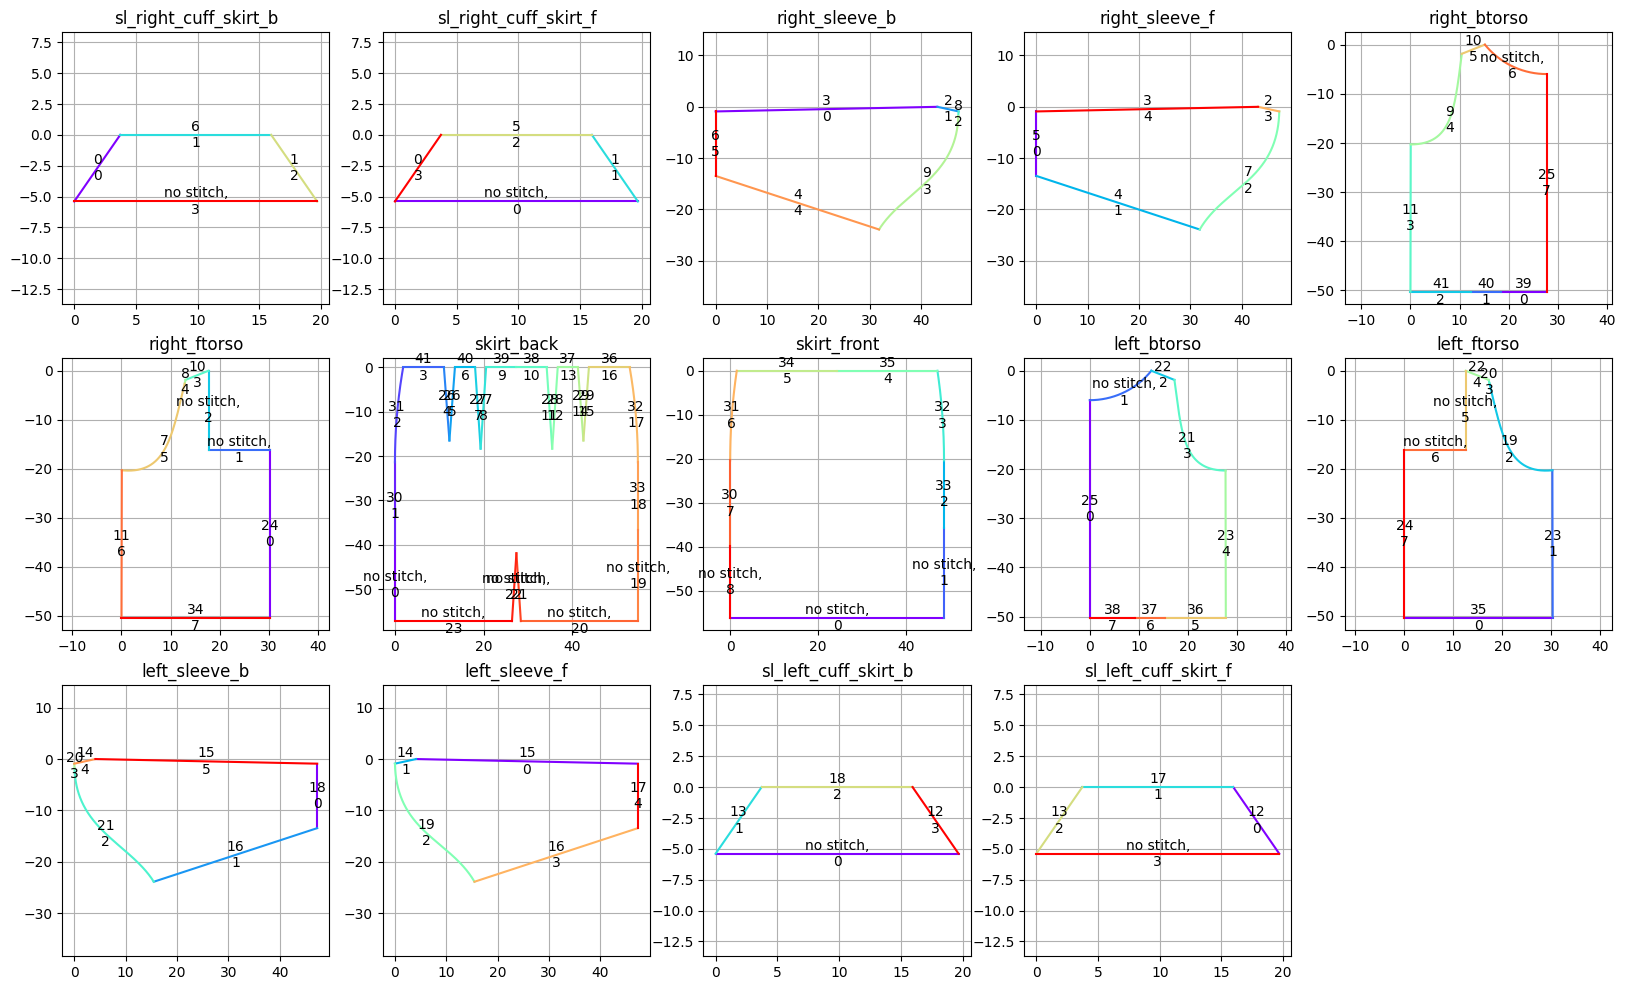

In [454]:
FIGLEN = 4
NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))
NCOLS = 5
NROWS = 3

plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
    ax = plt.subplot(NROWS, NCOLS, i + 1)
    ax.set_title(panel_name)
    plot_panel_info(
        ax, panel_name, panel_svg_path_dict, stitch_dict,
        N_SAMPLES=1000
    )
# plt.savefig(f"{garment_id}_panel_vis.png")
plt.show()

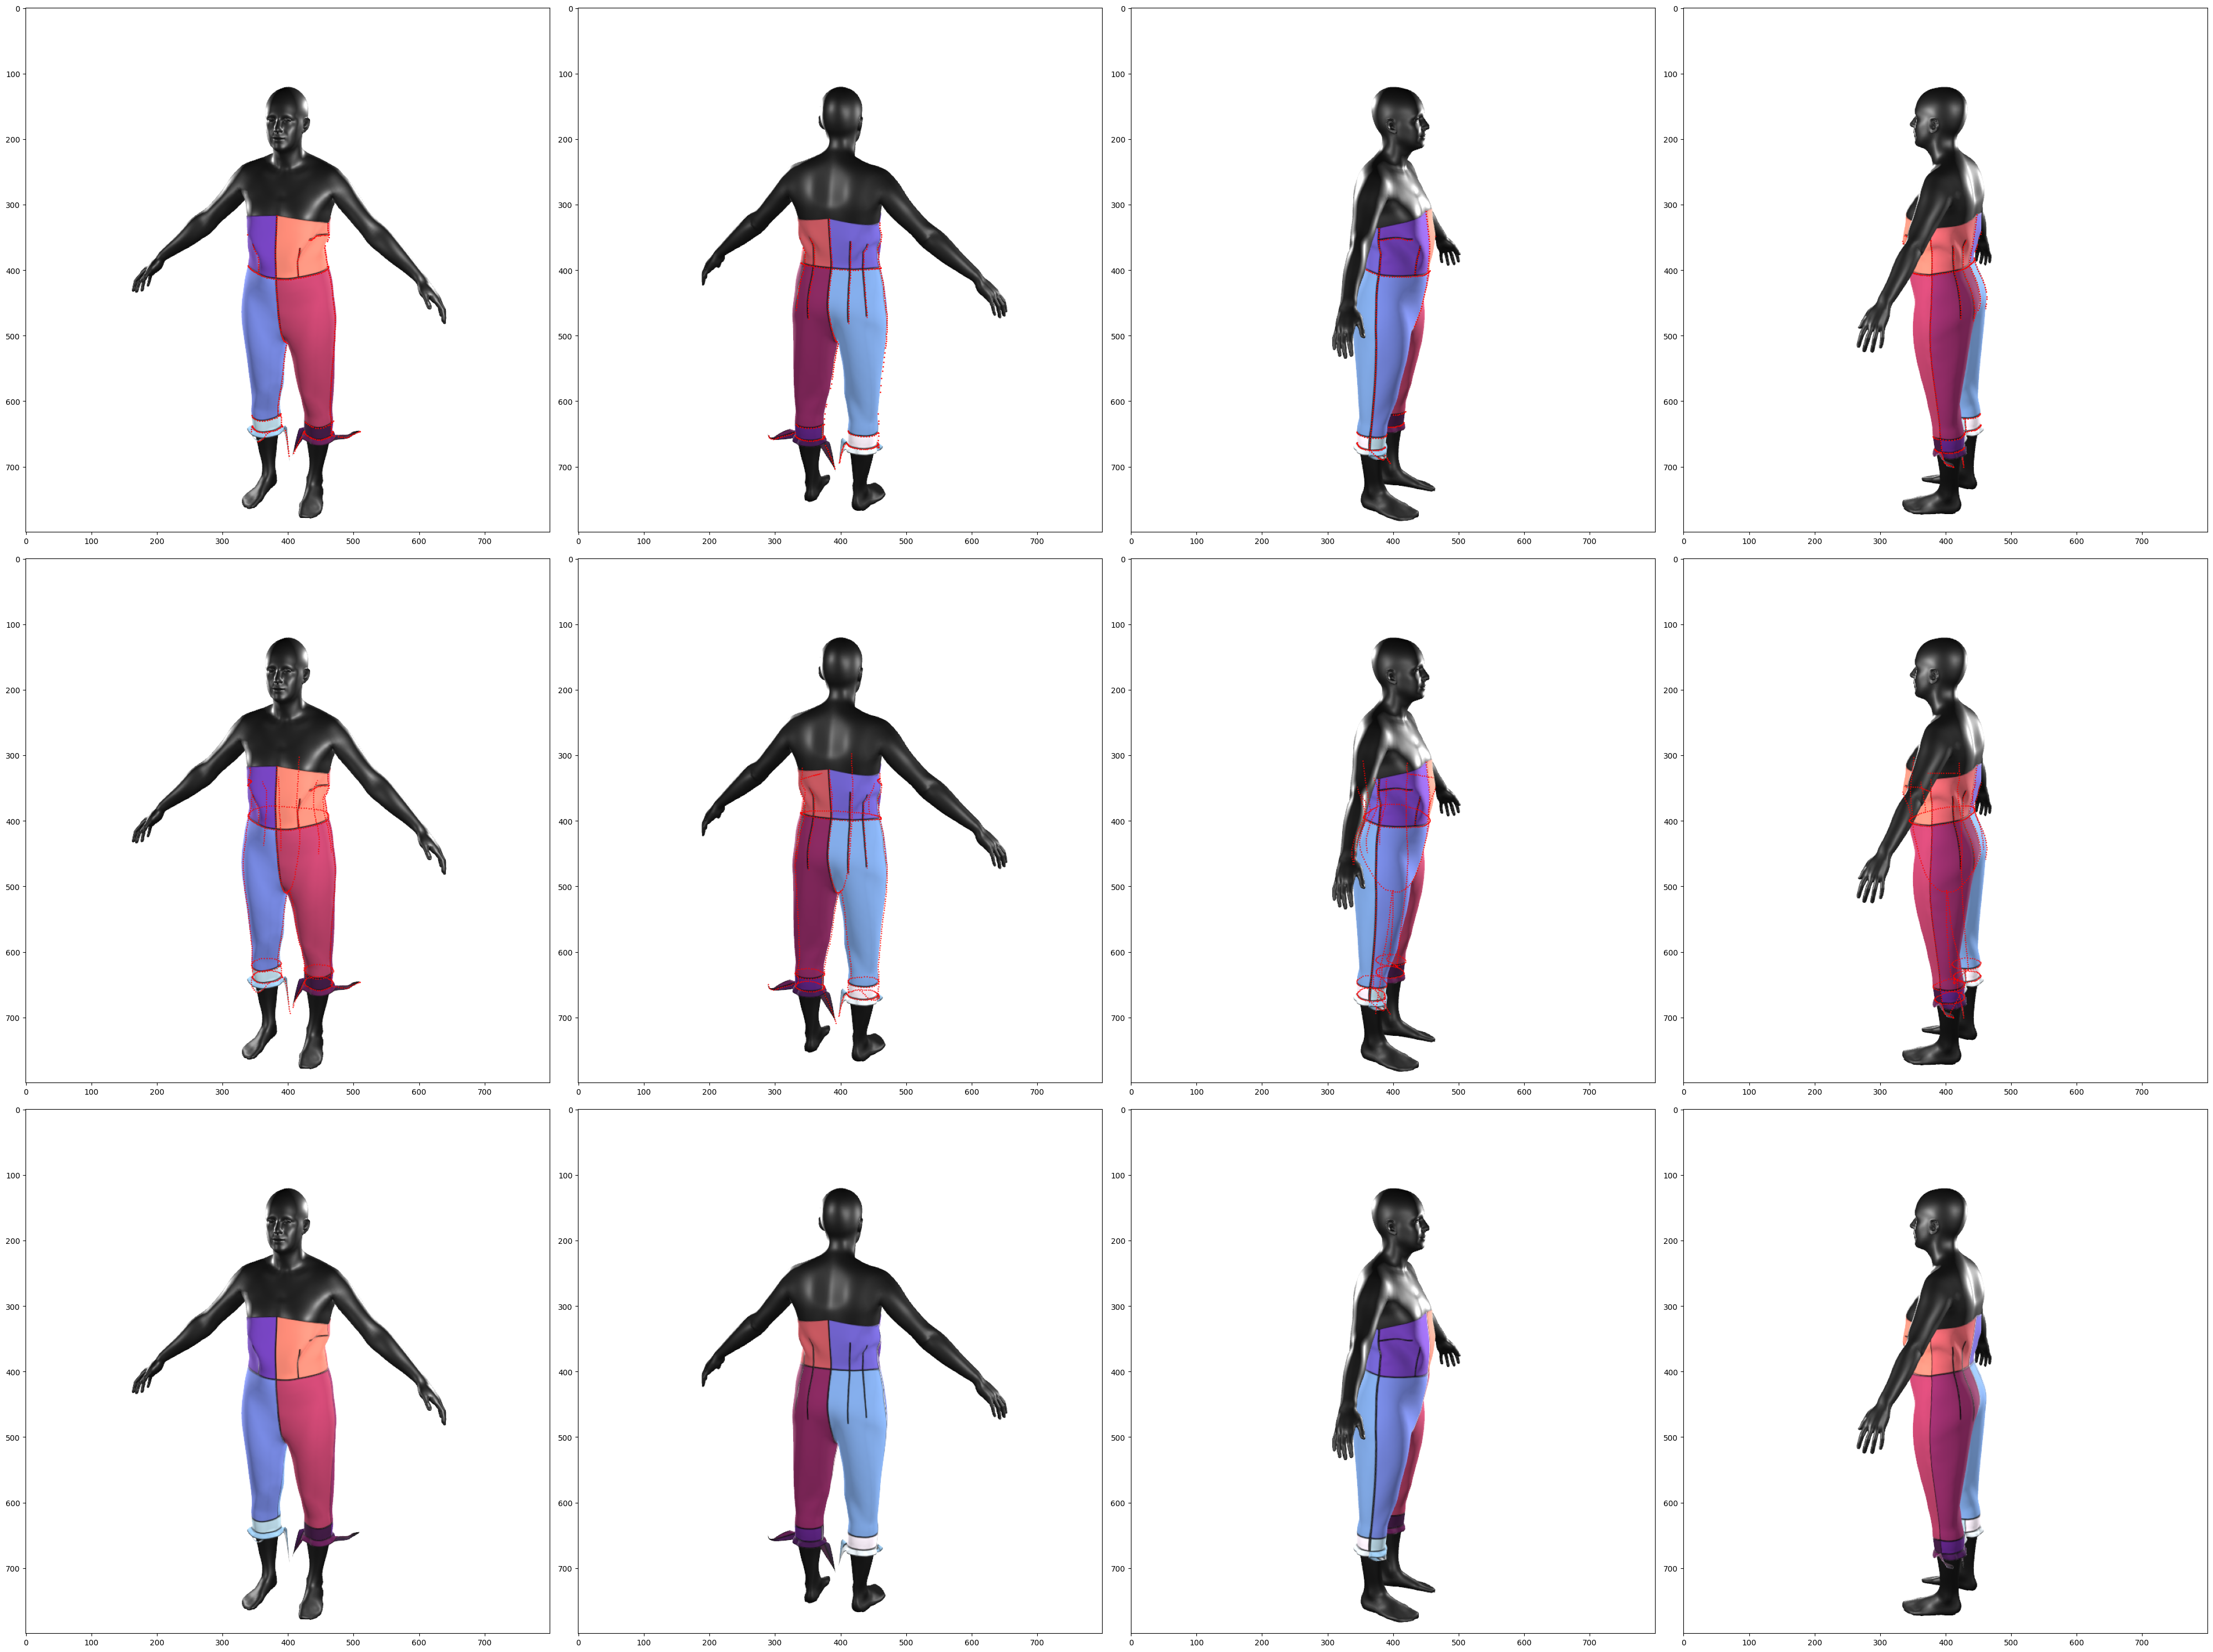

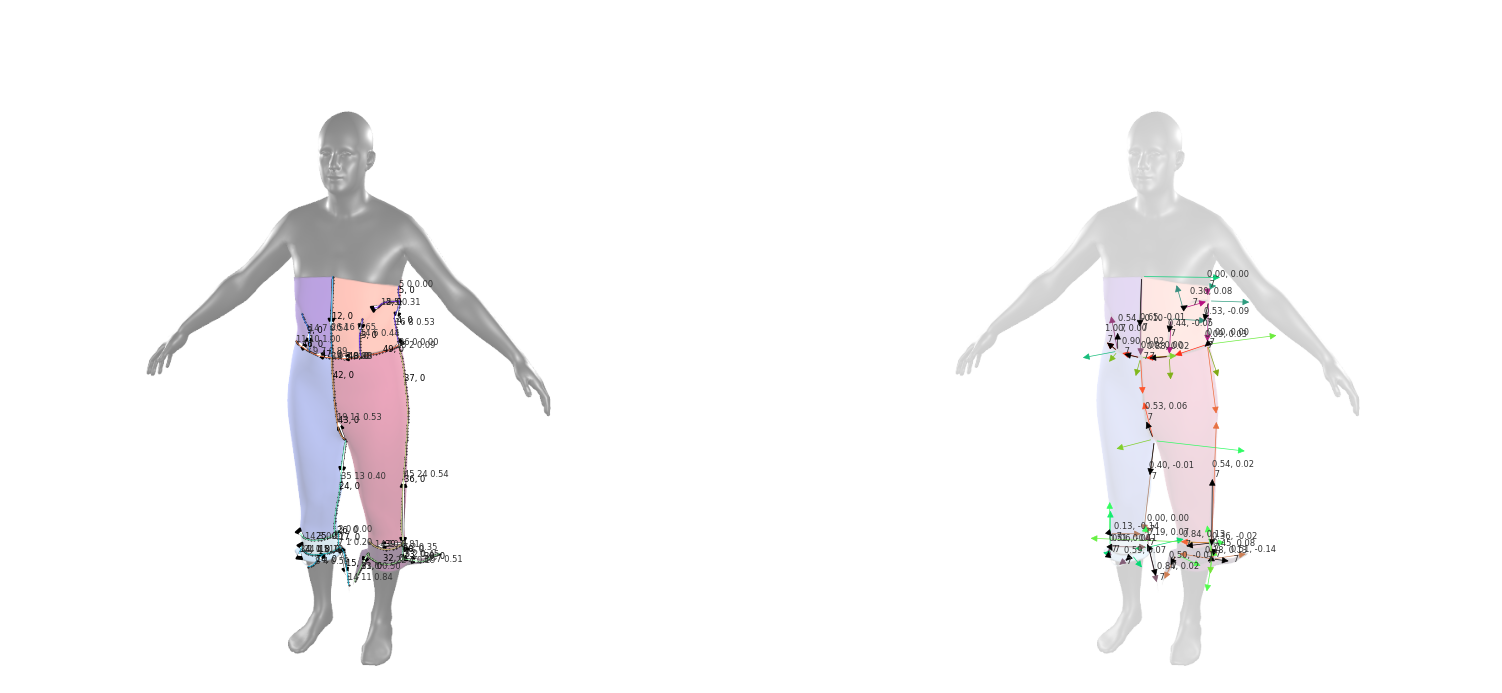

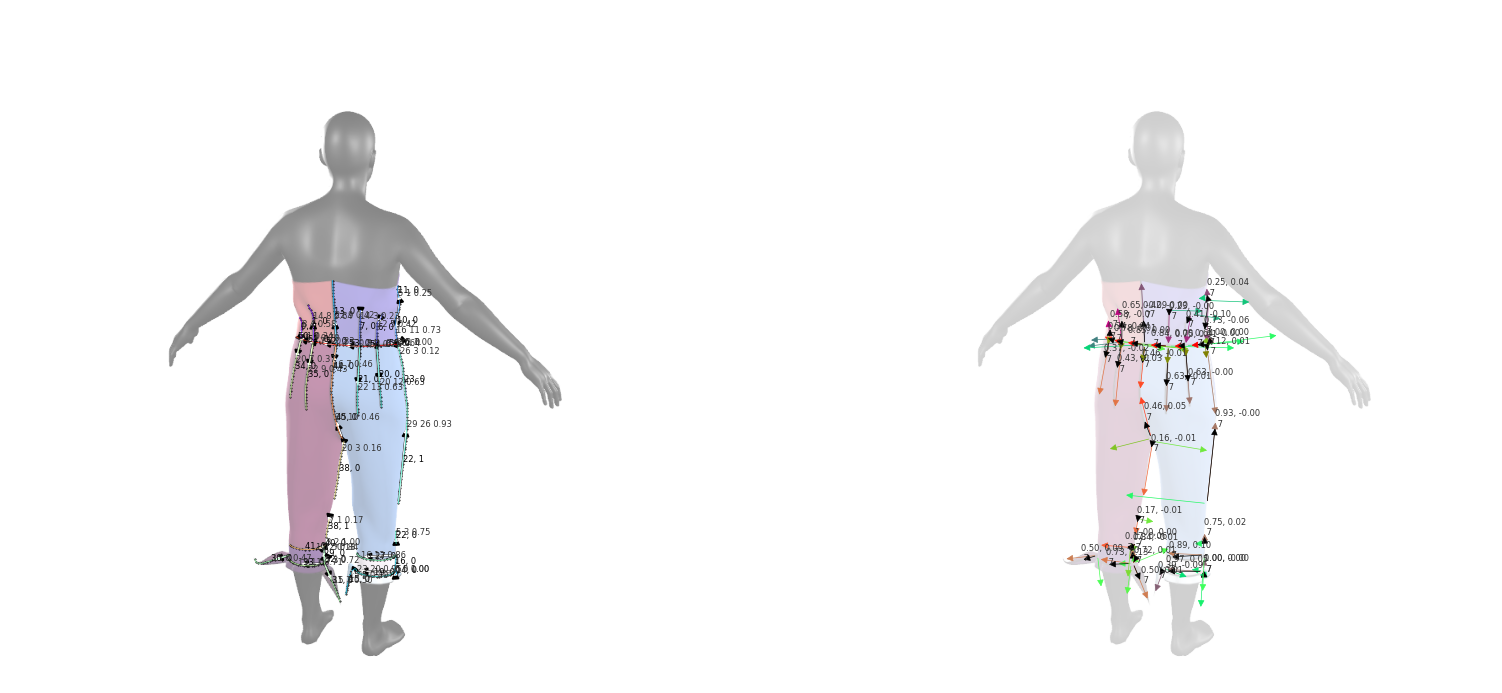

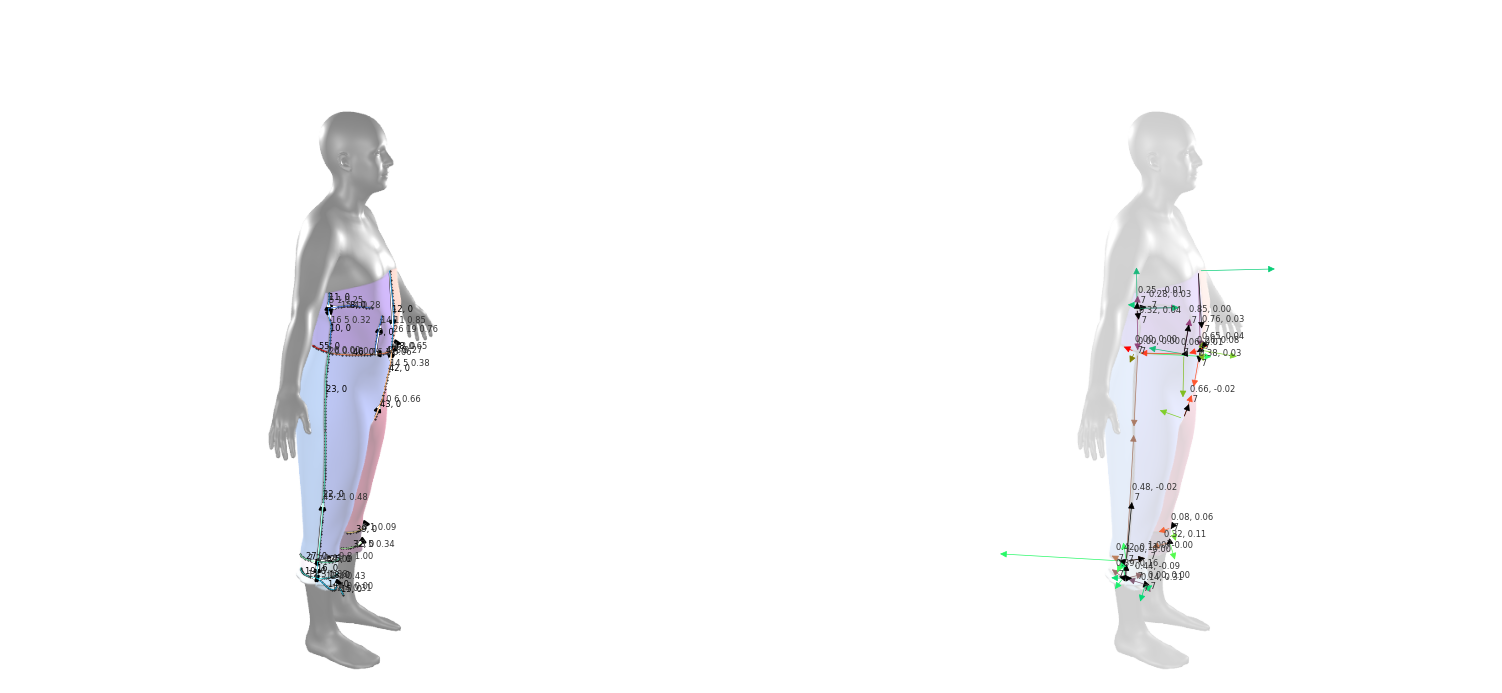

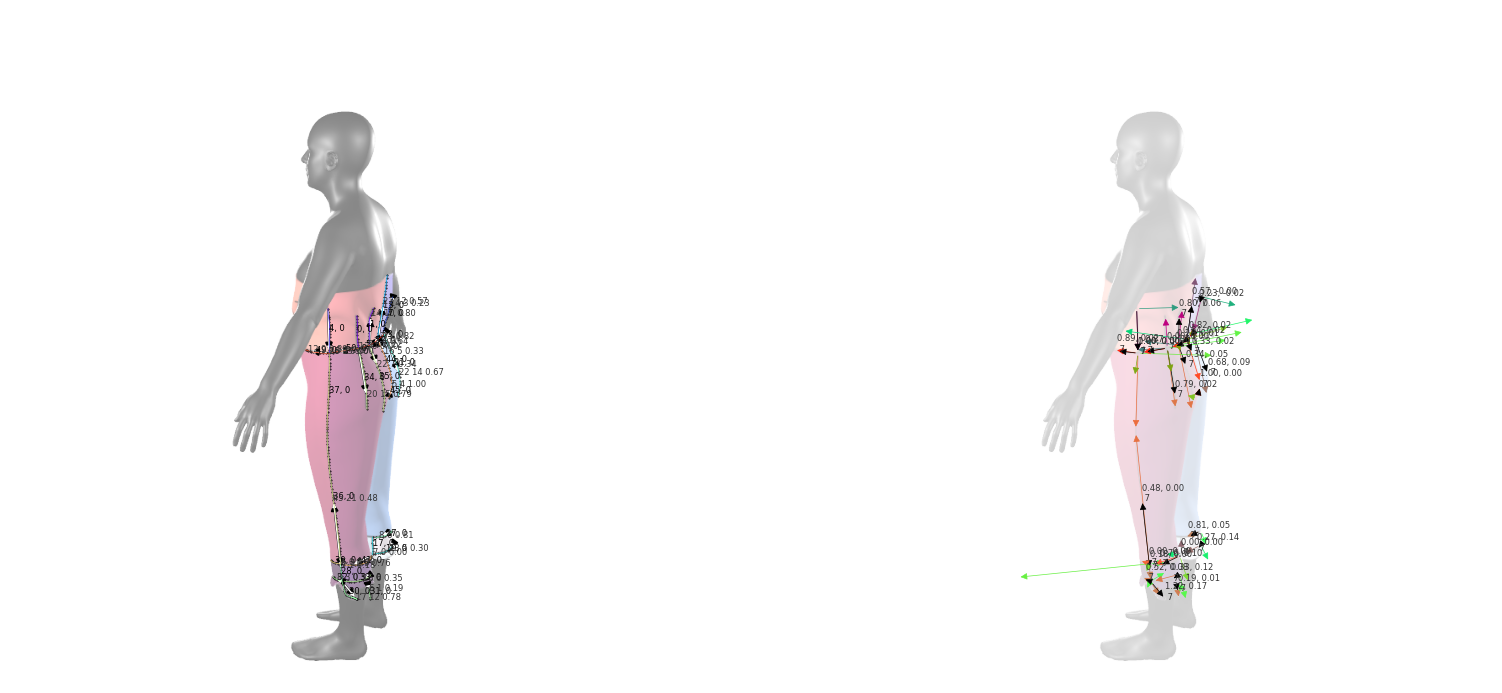

In [589]:
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_3/default_body/rand_005ZYVMOCL"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0BD28UCVO8"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0A36YXPNV0"


MIN_CONSEC_VERT_TO_BE_SEGMENT = 3
# Connect Disconnected vertices, if length of disconnected vertices <= MIN_CONSEC_VERT_TO_DISCONNECT
MIN_CONSEC_VERT_TO_DISCONNECT = 2
    

IDX = 1000

IDX = random.randint(0, len(garment_path_list) - 1)
IDX = 100365

garment_path = garment_path_list[IDX]
garment_id = os.path.basename(garment_path)
SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

# Get Garment Blueprint
panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

# Read Mesh
simulated_garment_mesh = trimesh.load_mesh(
    os.path.join(garment_path, f"{garment_id}_sim.ply"),
    process=False
)
simulated_garment_mesh.vertices = simulated_garment_mesh.vertices / 100

tex_image = PIL.Image.open(os.path.join(garment_path, f"{garment_id}_texture.png"))
texture = trimesh.visual.TextureVisuals(
    simulated_garment_mesh.visual.uv,
    image=tex_image
)
simulated_garment_mesh.visual = texture

idx_convert_map = v_id_map(simulated_garment_mesh.vertices)
idx_convert_map_arr = np.array(idx_convert_map)

# Read Vertex Label
with open(os.path.join(garment_path, f"{garment_id}_sim_segmentation.txt"), "r") as f:
    segmentation = list(map(
        lambda x : x.strip(),
        f.readlines()
    ))

stitch_vertex_mask_dict = {}
for k in stitch_dict.keys():
    raw_mask = list(map(
        lambda x : True if f"stitch_{k}" in x.split(",") else False,
        segmentation
    ))
    base_mask = np.array(list(map(
        lambda idx : True if raw_mask[idx] else False,
        idx_convert_map
    )))
    stitch_vertex_mask_dict[k] = base_mask


full_vertices = np.array(simulated_garment_mesh.vertices)
full_edges = np.array(simulated_garment_mesh.edges)
full_faces = np.array(simulated_garment_mesh.faces)

# Make filtered Mesh and conversion information
filtered2full_idx_map = {}
for idx, filtered_idx in enumerate(idx_convert_map):
    if filtered_idx in filtered2full_idx_map :
        filtered2full_idx_map[filtered_idx].append(idx)
    else:
        filtered2full_idx_map[filtered_idx] = [idx]

        
filtered_idx_list = []
filtered_vertices = []
for full_idx, filtered_idx in enumerate(idx_convert_map):
    if filtered_idx in filtered_idx_list:
        continue
    filtered_idx_list.append(filtered_idx)
    filtered_vertices.append(full_vertices[full_idx])
filtered_vertices = np.array(filtered_vertices)

filtered_edges = []
for orig_edge in full_edges:
    stt = idx_convert_map[orig_edge[0]]
    end = idx_convert_map[orig_edge[1]]
    filtered_edges.append([stt, end])
filtered_edges = np.array(filtered_edges)

filtered_faces = []
for idx, orig_face in enumerate(full_faces):
    v1, v2, v3 = sorted([
        idx_convert_map[orig_face[0]],
        idx_convert_map[orig_face[1]],
        idx_convert_map[orig_face[2]]
    ])
    filtered_faces.append([v1, v2, v3])
filtered_faces = np.array(filtered_faces)

filtered_mesh = trimesh.Trimesh(
    vertices=filtered_vertices,
    edges=filtered_edges,
    faces=filtered_faces,
    process=False
)

filtered_stitch_vertex_mask_dict = {}
for stitch_idx in stitch_vertex_mask_dict.keys():
    filtered_stitch_vertex_mask_dict[stitch_idx] = np.array(
        [False] * len(filtered_vertices)
    )
    for orig_vert_idx, val in enumerate(stitch_vertex_mask_dict[stitch_idx]):
        if val:
            filtered_vert_idx = idx_convert_map[orig_vert_idx]
            filtered_stitch_vertex_mask_dict[stitch_idx][filtered_vert_idx] = True


fltrd_vis_vert_mask_dict = {}
fltrd_proj_vert_pos_dict = {}







# ready pyrender meshes
body_material = pyrender.MetallicRoughnessMaterial(
    baseColorFactor=(0.0, 0.0, 0.0, 1.0),  # RGB color, Alpha
    metallicFactor=0.658,  # Range: [0.0, 1.0]
    roughnessFactor=0.5  # Range: [0.0, 1.0]
)
pyrender_body_mesh = pyrender.Mesh.from_trimesh(default_body_mesh, material=body_material)


material = simulated_garment_mesh.visual.material.to_pbr()
material.baseColorFactor = [1., 1., 1., 1.]
material.doubleSided = True  # color both face sides  

white_back = Image.new('RGBA', material.baseColorTexture.size, color=(255, 255, 255, 255))
white_back.paste(material.baseColorTexture)
material.baseColorTexture = white_back.convert('RGB')  

simulated_garment_mesh.visual.material = material

pyrender_garm_mesh = pyrender.Mesh.from_trimesh(
    simulated_garment_mesh, smooth=True
) 



rendered_image_dict = {}
depth_image_dict = {}
projected_vertex_pose_dict = {}
vertex_visibility_mask_dict = {}

for side in render_props["sides"]:
    scene = pyrender.Scene(bg_color=(1., 1., 1., 0.))
    
    scene.add(pyrender_garm_mesh)
    scene.add(pyrender_body_mesh)

    create_camera(
        pyrender,
        pyrender_body_mesh, scene, side,
        camera_location=render_props["front_camera_location"]
    )
    create_lights(scene, intensity=80.)
    
    camera_node = list(filter(
        lambda x : x.camera is not None,
        scene.get_nodes()
    ))[-1]
    
    renderer = pyrender.OffscreenRenderer(
        viewport_width=render_props["resolution"][0],
        viewport_height=render_props["resolution"][1]
    )
    
    flags = pyrender.RenderFlags.RGBA | pyrender.RenderFlags.SKIP_CULL_FACES
    color, depth = renderer.render(scene, flags=flags)
    
    rendered_image_dict[side] = Image.fromarray(color)
    depth_image_dict[side] = depth
    
    view_matrix = np.linalg.inv(scene.get_pose(camera_node))
    proj_matrix = camera_node.camera.get_projection_matrix(*render_props["resolution"])
    
    vertices_homog = np.hstack([simulated_garment_mesh.vertices, np.ones((simulated_garment_mesh.vertices.shape[0], 1))])
    
    view_proj = proj_matrix @ view_matrix
    projected = vertices_homog @ view_proj.T
    
    z_coords = projected[:, 2].copy()
    projected = projected[:, :3] / projected[:, 3:4]
    
    pixel_coords = np.zeros((projected.shape[0], 2))
    pixel_coords[:, 0] = (projected[:, 0] + 1.0) * render_props["resolution"][0] / 2.0
    pixel_coords[:, 1] = render_props["resolution"][1] - (projected[:, 1] + 1.0) * render_props["resolution"][1] / 2.0
    
    px = np.clip(pixel_coords[:, 0].astype(int), 0, render_props["resolution"][0] - 1)
    py = np.clip(pixel_coords[:, 1].astype(int), 0, render_props["resolution"][1] - 1)
    
    THRESHOLD = 0.09
    visibility_mask = (z_coords > 0) & \
                (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < render_props["resolution"][0]) & \
                (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < render_props["resolution"][1]) & \
                (z_coords + THRESHOLD < depth[py, px])
                # (depth[py, px] - THRESHOLD < z_coords) & (depth[py, px] + THRESHOLD > z_coords)
    
    projected_vertex_pose_dict[side] = pixel_coords
    vertex_visibility_mask_dict[side] = visibility_mask
    
    renderer.delete()


# for side, depth_image in depth_image_dict.items():
#     np.save(os.path.join(garment_path, f"{garment_id}_depth_{side}.npy"), depth_image)
# with open(os.path.join(garment_path, f"{garment_id}_projected_vertex_pose.json"), "w") as f:
#     json.dump( projected_vertex_pose_dict, f)
# with open(os.path.join(garment_path, f"{garment_id}_vertex_visibility_mask.json"), "w") as f:
#     json.dump(vertex_visibility_mask_dict, f)


FIGLEN = 10
NROWS = 3
NCOLS = len(vertex_visibility_mask_dict.keys())
plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, side in enumerate(vertex_visibility_mask_dict.keys()):
    plt.subplot(NROWS, NCOLS, i + 1)
    plt.imshow(rendered_image_dict[side])
    plt.tight_layout()
    vis_seam_pixel_coord = projected_vertex_pose_dict[side][
        np.logical_and(
            np.array(list(stitch_vertex_mask_dict.values())).sum(axis=0).astype(bool),
            vertex_visibility_mask_dict[side]
        )
    ]
    plt.scatter(
        vis_seam_pixel_coord[:, 0],
        vis_seam_pixel_coord[:, 1],
        c="red",
        s=1, alpha=0.5
    )
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS)
    plt.imshow(rendered_image_dict[side])
    plt.tight_layout()
    
    seam_pixel_coord = projected_vertex_pose_dict[side][
        np.array(list(stitch_vertex_mask_dict.values())).sum(axis=0).astype(bool)
    ]
    plt.scatter(
        seam_pixel_coord[:, 0],
        seam_pixel_coord[:, 1],
        c="red",
        s=0.5, alpha=0.5
    )
    
    plt.subplot(NROWS, NCOLS, i + 1 + NCOLS * 2)
    plt.imshow(rendered_image_dict[side])
    plt.tight_layout()

plt.show()




for side in vertex_visibility_mask_dict.keys():
    filtrd_idx_list = []
    fltrd_vis_mask = []
    fltrd_proj_vert_pos = []    
    for orig_idx, fltrd_idx in enumerate(idx_convert_map_arr):
        if fltrd_idx in filtrd_idx_list:
            continue
        filtrd_idx_list.append(fltrd_idx)
        fltrd_vis_mask.append(vertex_visibility_mask_dict[side][orig_idx])
        fltrd_proj_vert_pos.append(projected_vertex_pose_dict[side][orig_idx])

    fltrd_vis_vert_mask_dict[side] = fltrd_vis_mask
    fltrd_proj_vert_pos_dict[side] = fltrd_proj_vert_pos

vis_sim_segment_pos_dict = {}
for side in fltrd_vis_vert_mask_dict.keys():
    for stch_idx in filtered_stitch_vertex_mask_dict.keys():
        fltrd_stch_mask = filtered_stitch_vertex_mask_dict[stch_idx]
        fltrd_vis_mask = fltrd_vis_vert_mask_dict[side]
        
        mask = fltrd_stch_mask & fltrd_vis_mask
    
vis_sim_segment_pos_dict = {}
for side in fltrd_vis_vert_mask_dict.keys():
    for stch_idx in filtered_stitch_vertex_mask_dict.keys():
        fltrd_stch_mask = filtered_stitch_vertex_mask_dict[stch_idx]
        fltrd_vis_mask = fltrd_vis_vert_mask_dict[side]
        
        mask = fltrd_stch_mask & fltrd_vis_mask
        
fltrd_seam_line_dict = {}
for fltrd_stch_idx in filtered_stitch_vertex_mask_dict.keys():
    fltrd_stch_vert_map = filtered_stitch_vertex_mask_dict[fltrd_stch_idx]
    fltrd_stch_vert_idx_arr = np.where(fltrd_stch_vert_map)[0]
    
    adj_dict = {}
    for v1, v2 in filtered_edges:
        if v1 in fltrd_stch_vert_idx_arr and v2 in fltrd_stch_vert_idx_arr:
            if v1 not in adj_dict: adj_dict[v1] = set()
            if v2 not in adj_dict: adj_dict[v2] = set()
            adj_dict[v1].add(v2)
            adj_dict[v2].add(v1)
    
    endpoints = [
        v for v in fltrd_stch_vert_idx_arr if len(adj_dict.get(v, set())) == 1
    ]
    if len(endpoints) != 2:
        
        print("stitch idx", fltrd_stch_idx)
        print(fltrd_stch_vert_idx_arr)
        print(f"Warning: Found {len(endpoints)} endpoints, expected 2. Path may not be linear.")
        continue
    
    seam_vert_idx_list = [endpoints[0]]
    while len(seam_vert_idx_list) < len(fltrd_stch_vert_idx_arr):
        current_vert = seam_vert_idx_list[-1]
        neighbors = adj_dict[current_vert]
        next_vert = next((v for v in neighbors if v not in seam_vert_idx_list), None)
        if next_vert is None:
            break
        seam_vert_idx_list.append(next_vert)
    fltrd_seam_line_dict[fltrd_stch_idx] = seam_vert_idx_list

fltrd_vis_seam_line_dict = {}
for side in fltrd_vis_vert_mask_dict.keys() :
    fltrd_vis_seam_line_dict[side] = {}
    vis_mask = np.array(fltrd_vis_vert_mask_dict[side]).astype(bool)
    for stch_idx in fltrd_seam_line_dict.keys():
        
        seam_vert_idx_list = np.array(fltrd_seam_line_dict[stch_idx])
        vis_list = []
        for seam_vert_idx in seam_vert_idx_list :
            vis_list.append(vis_mask[seam_vert_idx])
        vis_list = np.array(vis_list)

        # If length of disconnection between visible seam vertices
        # is less then MIN_CONSEC_VERT_TO_DISCONNECT,
        # consider the disconnection is connected
        # (which change invisible seam vertices to visible)
        idx = 0
        while idx < len(vis_list) :
            if idx >= len(vis_list) - 2 :
                break
            while not (vis_list[idx] == True and vis_list[idx + 1] == False) :
                if idx >= len(vis_list) - 2 :
                    break
                idx += 1
            if idx >= len(vis_list) - 2 :
                break
            window_end_idx = min(idx + MIN_CONSEC_VERT_TO_DISCONNECT + 1, len(vis_list) - 1)
            for rid in range(window_end_idx, idx, -1) :
                if vis_list[rid] == True :
                    vis_list[idx:rid] = True
                    break
            idx = rid
            
            
        # If length of connection between visible seam vertices
        # is less then MIN_CONSEC_VERT_TO_BE_SEGMENT,
        # consider the connection is not a segment
        # (which change visible seam vertices to invisible)
        idx = 0
        while idx < len(vis_list) :
            if vis_list[idx] != True :
                idx += 1
                continue
            idx2 = idx + 1
            while idx2 < len(vis_list) and vis_list[idx2] == True :
                idx2 += 1
            if idx2 - idx < MIN_CONSEC_VERT_TO_BE_SEGMENT :
                vis_list[idx:idx2] = False
            idx = idx2
            
        line_segment_idx_arr_list = []
        line_segment_pos_arr_list = []
        if True in vis_list :
            idx = vis_list.tolist().index(True)
            while idx < len(vis_list) :
                line_segment_idx_list = []
                line_segment_pos_list = []
                while idx < len(vis_list) and vis_list[idx] == True :
                    line_segment_idx_list.append(
                        seam_vert_idx_list[idx]
                    )
                    line_segment_pos_list.append(
                        fltrd_proj_vert_pos_dict[side][seam_vert_idx_list[idx]]
                    )
                    idx += 1
                if len(line_segment_idx_list) > 0 :
                    line_segment_idx_arr_list.append(np.array(line_segment_idx_list))
                    line_segment_pos_arr_list.append(np.array(line_segment_pos_list))
                idx += 1
        
        if len(line_segment_pos_arr_list) > 0 :
            segment_edge_len_arr_list = []
            segment_t_arr_list = []
            segment_u_arr_list = []
            segment_v_arr_list = []
            for segment_pos_arr in line_segment_pos_arr_list :
                i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
                j_vec = np.array([i_vec[1], -i_vec[0]])
                
                i_vec_normalized = i_vec / np.linalg.norm(i_vec)
                j_vec_normalized = j_vec / np.linalg.norm(j_vec)
                
                edge_len_arr = np.concatenate((
                    [0],
                    np.linalg.norm(segment_pos_arr[1:] - segment_pos_arr[:-1], axis=1)
                ))
                segment_edge_len_arr_list.append(edge_len_arr)
                t_arr = np.cumsum(edge_len_arr) / np.sum(edge_len_arr)
                
                vect_arr = segment_pos_arr - segment_pos_arr[0]
                u_arr = np.sum(vect_arr * i_vec_normalized, axis=1) / np.linalg.norm(i_vec)
                v_arr = np.sum(vect_arr * j_vec_normalized, axis=1) / np.linalg.norm(j_vec)
                
                segment_t_arr_list.append(t_arr)
                segment_u_arr_list.append(u_arr)
                segment_v_arr_list.append(v_arr)
            
                
                if len(t_arr) != len(segment_pos_arr) :
                    print(side, stch_idx)
                    print(segment_pos_arr.shape, t_arr.shape, u_arr.shape, v_arr.shape)
                    print("error")
                
                
                if len(t_arr) != len(u_arr) or len(t_arr) != len(v_arr) :
                    print(side, stch_idx)
                    print(edge_len_arr.shape, t_arr.shape, u_arr.shape, v_arr.shape)
                    print("error")
                
                error_num = np.sum(
                    vect_arr - (u_arr.reshape(-1, 1) * i_vec.reshape(1, -1) + v_arr.reshape(-1, 1) * j_vec.reshape(1, -1))
                )
                if error_num > 1e-6 :
                    print(side, stch_idx)
                    print(vect_arr.shape, u_arr.shape, v_arr.shape)
                    print(error_num)
                    print("error")
            fltrd_vis_seam_line_dict[side][stch_idx] = {
                "raw_idx_arr" : seam_vert_idx_list,
                "raw_vis_mask" : vis_list,
                "segment_idx_arr_list" : line_segment_idx_arr_list,
                "segment_pos_arr_list" : line_segment_pos_arr_list,
                "segment_edge_len_arr_list" : segment_edge_len_arr_list,
                "segment_t_arr_list" : segment_t_arr_list,
                "segment_u_arr_list" : segment_u_arr_list,
                "segment_v_arr_list" : segment_v_arr_list
            }





STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    fltrd_vis_seam_line_dict.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

for side in fltrd_vis_seam_line_dict.keys():
    plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN))
    ax1 = plt.subplot(1, NCOLS, 1)
    ax1.imshow(rendered_image_dict[side], alpha=0.5)
    ax1.axis("off")
    
    ax2 = plt.subplot(1, NCOLS, 2)
    ax2.imshow(rendered_image_dict[side], alpha=0.2)
    ax2.axis("off")

    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
        for segment_idx, (
            segment_idx_arr, segment_pos_arr,
            segment_edge_len_arr, segment_t_arr,
            segment_u_arr, segment_v_arr
        ) in enumerate(zip(
            seam_dict["segment_idx_arr_list"],
            seam_dict["segment_pos_arr_list"],
            seam_dict["segment_edge_len_arr_list"],
            seam_dict["segment_t_arr_list"],
            seam_dict["segment_u_arr_list"],
            seam_dict["segment_v_arr_list"]
        )):
            
            i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
            j_vec = np.array([i_vec[1], -i_vec[0]])
            
            
            # print(
            #     len(segment_idx_arr), len(segment_pos_arr),
            #     len(edge_len_arr), len(t_arr),
            #     len(u_arr), len(v_arr)
            # )
            
            ax1.annotate(
                f"{seam_idx}, {segment_idx}",
                xy = (segment_pos_arr.mean(axis=0)),
                xytext = (segment_pos_arr.mean(axis=0)),
                fontsize=6
            )
            ax1.plot(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                '-',
                color=colors[seam_idx],
                linewidth=0.5
            )
            ax1.scatter(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                color="black",
                s=0.2
            )
            
            
            arrow_i = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[0] + i_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color=np.mean(
                    [colors[seam_idx], np.array([1, 0, 0, 1])],
                    axis=0
                ),
                linewidth=0.5
            )
            
            arrow_j = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[0] + j_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color=np.mean(
                    [colors[seam_idx], np.array([0, 1, 0, 1])],
                    axis=0
                ),
                linewidth=0.5
            )
            ax2.add_patch(arrow_i)
            ax2.add_patch(arrow_j)
            
            random_idx = random.randint(0, len(segment_pos_arr) - 1)
            t = segment_t_arr[random_idx]
            u = segment_u_arr[random_idx]
            v = segment_v_arr[random_idx]
            
            ax1.annotate(
                f"{len(segment_pos_arr)} {random_idx} {t:.2f}",
                xy = (segment_pos_arr[random_idx]),
                xytext = (segment_pos_arr[random_idx]),
                fontsize=6, color=(0.2, 0.2, 0.2, 1)
            )
            
            arrow_1 = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[random_idx],
                arrowstyle='-|>',
                mutation_scale=10,
                color='black',
                linewidth=1.5
            )
            arrow_2 = FancyArrowPatch(
                segment_pos_arr[0],
                segment_pos_arr[0] + u * i_vec + v * j_vec,
                arrowstyle='-|>',
                mutation_scale=5,
                color='white',
                linewidth=1
            )
            ax1.add_patch(arrow_1)
            ax1.add_patch(arrow_2)
            
            
            ax2.annotate(
                f"{u:.2f}, {v:.2f} \n {len(vect_arr)}",
                xy = (segment_pos_arr[random_idx]),
                xytext = (segment_pos_arr[random_idx]),
                fontsize=6, color=(0.2, 0.2, 0.2, 1)
            )
            
            arrow_2 = FancyArrowPatch(
                segment_pos_arr[0],
                segment_pos_arr[0] + u * i_vec + v * j_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color='black',
                linewidth=0.5
            )
            ax2.add_patch(arrow_2)
        

In [591]:
type(rendered_image_dict["front"])

PIL.Image.Image

()

In [557]:
IDX

100365

In [ ]:
# 100365

In [588]:

for side in fltrd_vis_seam_line_dict.keys():

    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
        for segment_idx, (
            segment_idx_arr, segment_pos_arr,
            segment_edge_len_arr, segment_t_arr,
            segment_u_arr, segment_v_arr
        ) in enumerate(zip(
            seam_dict["segment_idx_arr_list"],
            seam_dict["segment_pos_arr_list"],
            seam_dict["segment_edge_len_arr_list"],
            seam_dict["segment_t_arr_list"],
            seam_dict["segment_u_arr_list"],
            seam_dict["segment_v_arr_list"]
        )):
            
            
            if len(segment_pos_arr) != len(segment_t_arr) :
                print(
                    side, seam_idx, segment_idx, '\t',
                    "segm_idx", segment_idx_arr.shape, 
                    "segm_pos", segment_pos_arr.shape,
                    "segm_edge_len", segment_edge_len_arr.shape,
                    "segm_t", segment_t_arr.shape,
                    "segm_u", segment_u_arr.shape,
                    "segm_v", segment_v_arr.shape
                )
                continue
            
            
            random_idx = random.randint(0, len(segment_pos_arr) - 1)
            t = segment_t_arr[random_idx]
            u = segment_u_arr[random_idx]
            v = segment_v_arr[random_idx]
            

        